**<font size='7'>NOTEBOOK RESULTS</font>** 

Authors: **Massimo Romano** (2043836), **Paolo Renzi** (1887793)

In this notebook we show the results of our experiments. 

<font size='4'>Training hyperparameters</font>

- *num_epochs*: **100**
- *batch_size*: **64**
- *learning_rate*: **0.01**
- *optimizer*: **adam**
- *patience*: **5**
- *lr_scheduler*: **0.25**
- *label_smoothing*: **0.1**

<font size='4'> Model hyperparameters</font>

- *dropout_rate*: **0.1**
- *n_filter*: **39**
- *num_features*: **39**
- *generator_type*: **conv**
- *kernel_size*: **2**
- *omega_0*: **25**
- *hidden_scale*: **1**
- *af_type*: **sin**

In particular we have done the following trials:

- *TAB Trials*: we have tested CkTIM and TIM networks without augmentation with different numbers of TAB

- *Augmentation Trials*: we have tested CkTIM network with TAB=6 (the better case of previous trials) without and with augmentation, to see how augmentation increase performances

**IMPORT**

In [1]:
import matplotlib.pyplot as plt
import seaborn as sns
import dataloader.utils as utils

**DATA LOADING**

In this section we load the json files that contain training/validation loss and accuracy

In [2]:
# load the dictionary {'model': [model_name], 'epoch': [1, 2 ...], 'loss': [1.9, 1.8 ...], 'accuracy': [0.6, 0.7, ...], 'recall': [0.2, 0.3, ...], 'precision': [0.3, 0.4, ...], 'f1-score': [0.5, 0.6, ...]}
data_training_cktim_tab1 = utils.load_metrics('./results/CkTIM_TAB1/training_metrics.json')
data_validation_cktim_tab1= utils.load_metrics('./results/CkTIM_TAB1/validation_metrics.json')

data_training_cktim_tab3 = utils.load_metrics('./results/CkTIM_TAB3/training_metrics.json')
data_validation_cktim_tab3 = utils.load_metrics('./results/CkTIM_TAB3/validation_metrics.json')

data_training_cktim_tab6= utils.load_metrics('./results/CkTIM_TAB6/training_metrics.json')
data_validation_cktim_tab6 = utils.load_metrics('./results/CkTIM_TAB6/validation_metrics.json')

data_training_tim_tab1 = utils.load_metrics('./results/TIM_TAB1/training_metrics.json')
data_validation_tim_tab1 = utils.load_metrics('./results/TIM_TAB1/validation_metrics.json')

data_training_tim_tab3 = utils.load_metrics('./results/TIM_TAB3/training_metrics.json')
data_validation_tim_tab3 = utils.load_metrics('./results/TIM_TAB3/validation_metrics.json')

data_training_tim_tab6 = utils.load_metrics('./results/TIM_TAB6/training_metrics.json')
data_validation_tim_tab6 = utils.load_metrics('./results/TIM_TAB6/validation_metrics.json')

data_training_augmented_cktim6 = utils.load_metrics('./results/CkTIM_TAB6_aug/training_metrics.json')
data_validation_augmented_cktim6 = utils.load_metrics('./results/CkTIM_TAB6_aug/validation_metrics.json')

# Load the epochs, loss and accuracy in training and validation for the plots
epochs = data_training_cktim_tab1['epoch'] 

training_loss_cktim_tab1 = data_training_cktim_tab1['loss']
training_acc_cktim_tab1 = data_training_cktim_tab1['accuracy']
validation_loss_cktim_tab1 = data_validation_cktim_tab1['loss']
validation_acc_cktim_tab1 = data_validation_cktim_tab1['accuracy']

training_loss_cktim_tab3 = data_training_cktim_tab3['loss']
training_acc_cktim_tab3 = data_training_cktim_tab3['accuracy']
validation_loss_cktim_tab3 = data_validation_cktim_tab3['loss']
validation_acc_cktim_tab3 = data_validation_cktim_tab3['accuracy']

training_loss_cktim_tab6 = data_training_cktim_tab6['loss']
training_acc_cktim_tab6 = data_training_cktim_tab6['accuracy']
validation_loss_cktim_tab6 = data_validation_cktim_tab6['loss']
validation_acc_cktim_tab6 = data_validation_cktim_tab6['accuracy']

training_loss_tim_tab1 = data_training_tim_tab1['loss']
training_acc_tim_tab1 = data_training_tim_tab1['accuracy']
validation_loss_tim_tab1 = data_validation_tim_tab1['loss']
validation_acc_tim_tab1 = data_validation_tim_tab1['accuracy']

training_loss_tim_tab3 = data_training_tim_tab3['loss']
training_acc_tim_tab3 = data_training_tim_tab3['accuracy']
validation_loss_tim_tab3 = data_validation_tim_tab3['loss']
validation_acc_tim_tab3 = data_validation_tim_tab3['accuracy']

training_loss_tim_tab6 = data_training_tim_tab6['loss']
training_acc_tim_tab6 = data_training_tim_tab6['accuracy']
validation_loss_tim_tab6 = data_validation_tim_tab6['loss']
validation_acc_tim_tab6 = data_validation_tim_tab6['accuracy']

training_loss_aug_cktim_tab6 = data_training_augmented_cktim6['loss']
training_acc_aug_cktim_tab6 = data_training_augmented_cktim6['accuracy']
validation_loss_aug_cktim_tab6 = data_validation_augmented_cktim6['loss']
valdation_acc_aug_cktim_tab6 = data_validation_augmented_cktim6['accuracy']

Metrics loaded ./results/CkTIM_TAB1/training_metrics.json
Metrics loaded ./results/CkTIM_TAB1/validation_metrics.json
Metrics loaded ./results/CkTIM_TAB3/training_metrics.json
Metrics loaded ./results/CkTIM_TAB3/validation_metrics.json
Metrics loaded ./results/CkTIM_TAB6/training_metrics.json
Metrics loaded ./results/CkTIM_TAB6/validation_metrics.json
Metrics loaded ./results/TIM_TAB1/training_metrics.json
Metrics loaded ./results/TIM_TAB1/validation_metrics.json
Metrics loaded ./results/TIM_TAB3/training_metrics.json
Metrics loaded ./results/TIM_TAB3/validation_metrics.json
Metrics loaded ./results/TIM_TAB6/training_metrics.json
Metrics loaded ./results/TIM_TAB6/validation_metrics.json
Metrics loaded ./results/CkTIM_TAB6_aug/training_metrics.json
Metrics loaded ./results/CkTIM_TAB6_aug/validation_metrics.json


<font size='6'>Loss/Accuracy CkTIM</font>

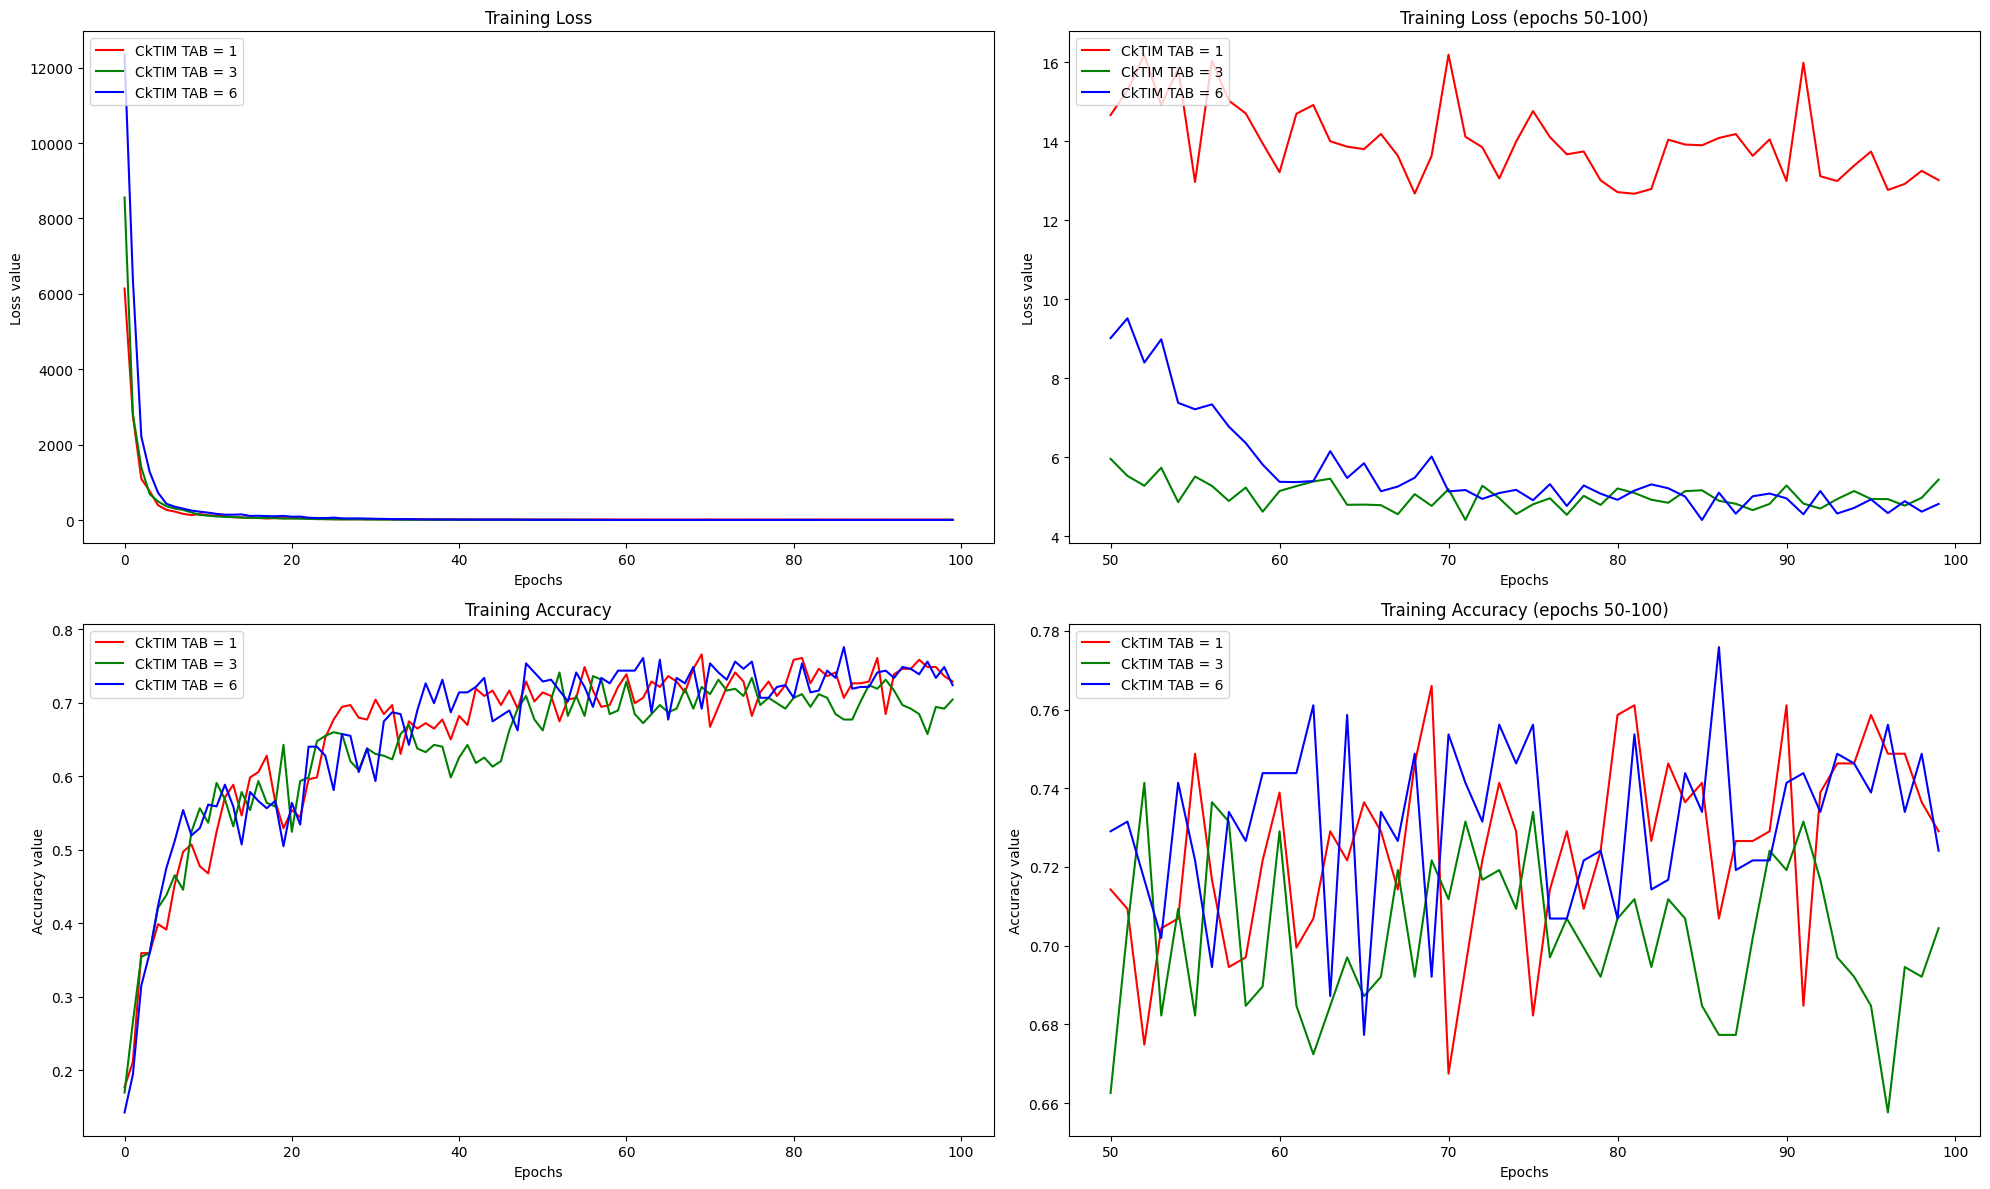

In [7]:
fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(20,12))

# Set the functions, title, x_label, y_label and legend for the loss 
ax[0,0].plot(epochs, training_loss_cktim_tab1, label='CkTIM TAB = 1', color='r')
ax[0,0].plot(epochs, training_loss_cktim_tab3, label='CkTIM TAB = 3', color='g')
ax[0,0].plot(epochs, training_loss_cktim_tab6, label='CkTIM TAB = 6', color='b')
ax[0,0].set_title('Training Loss')
ax[0,0].set_xlabel('Epochs')
ax[0,0].set_ylabel('Loss value')
ax[0,0].legend(loc='upper left')

# Set the functions, title, x_label, y_label and legend for the loss 
ax[0,1].plot(epochs[50:], training_loss_cktim_tab1[50:], label='CkTIM TAB = 1', color='r')
ax[0,1].plot(epochs[50:], training_loss_cktim_tab3[50:], label='CkTIM TAB = 3', color='g')
ax[0,1].plot(epochs[50:], training_loss_cktim_tab6[50:], label='CkTIM TAB = 6', color='b')
ax[0,1].set_title('Training Loss (epochs 50-100)')
ax[0,1].set_xlabel('Epochs')
ax[0,1].set_ylabel('Loss value')
ax[0,1].legend(loc='upper left')

# Set the functions, title, x_label, y_label and legend for the loss 
ax[1,0].plot(epochs, training_acc_cktim_tab1, label='CkTIM TAB = 1', color='r')
ax[1,0].plot(epochs, training_acc_cktim_tab3, label='CkTIM TAB = 3', color='g')
ax[1,0].plot(epochs, training_acc_cktim_tab6, label='CkTIM TAB = 6', color='b')
ax[1,0].set_title('Training Accuracy')
ax[1,0].set_xlabel('Epochs')
ax[1,0].set_ylabel('Accuracy value')
ax[1,0].legend(loc='upper left')

# Set the functions, title, x_label, y_label and legend for the loss 
ax[1,1].plot(epochs[50:], training_acc_cktim_tab1[50:], label='CkTIM TAB = 1', color='r')
ax[1,1].plot(epochs[50:], training_acc_cktim_tab3[50:], label='CkTIM TAB = 3', color='g')
ax[1,1].plot(epochs[50:], training_acc_cktim_tab6[50:], label='CkTIM TAB = 6', color='b')
ax[1,1].set_title('Training Accuracy (epochs 50-100)')
ax[1,1].set_xlabel('Epochs')
ax[1,1].set_ylabel('Accuracy value')
ax[1,1].legend(loc='upper left')

# Display the plot
plt.tight_layout()  # This helps to prevent overlapping of subplots
plt.show()

<font size='6'>Loss/Accuracy TIM</font>

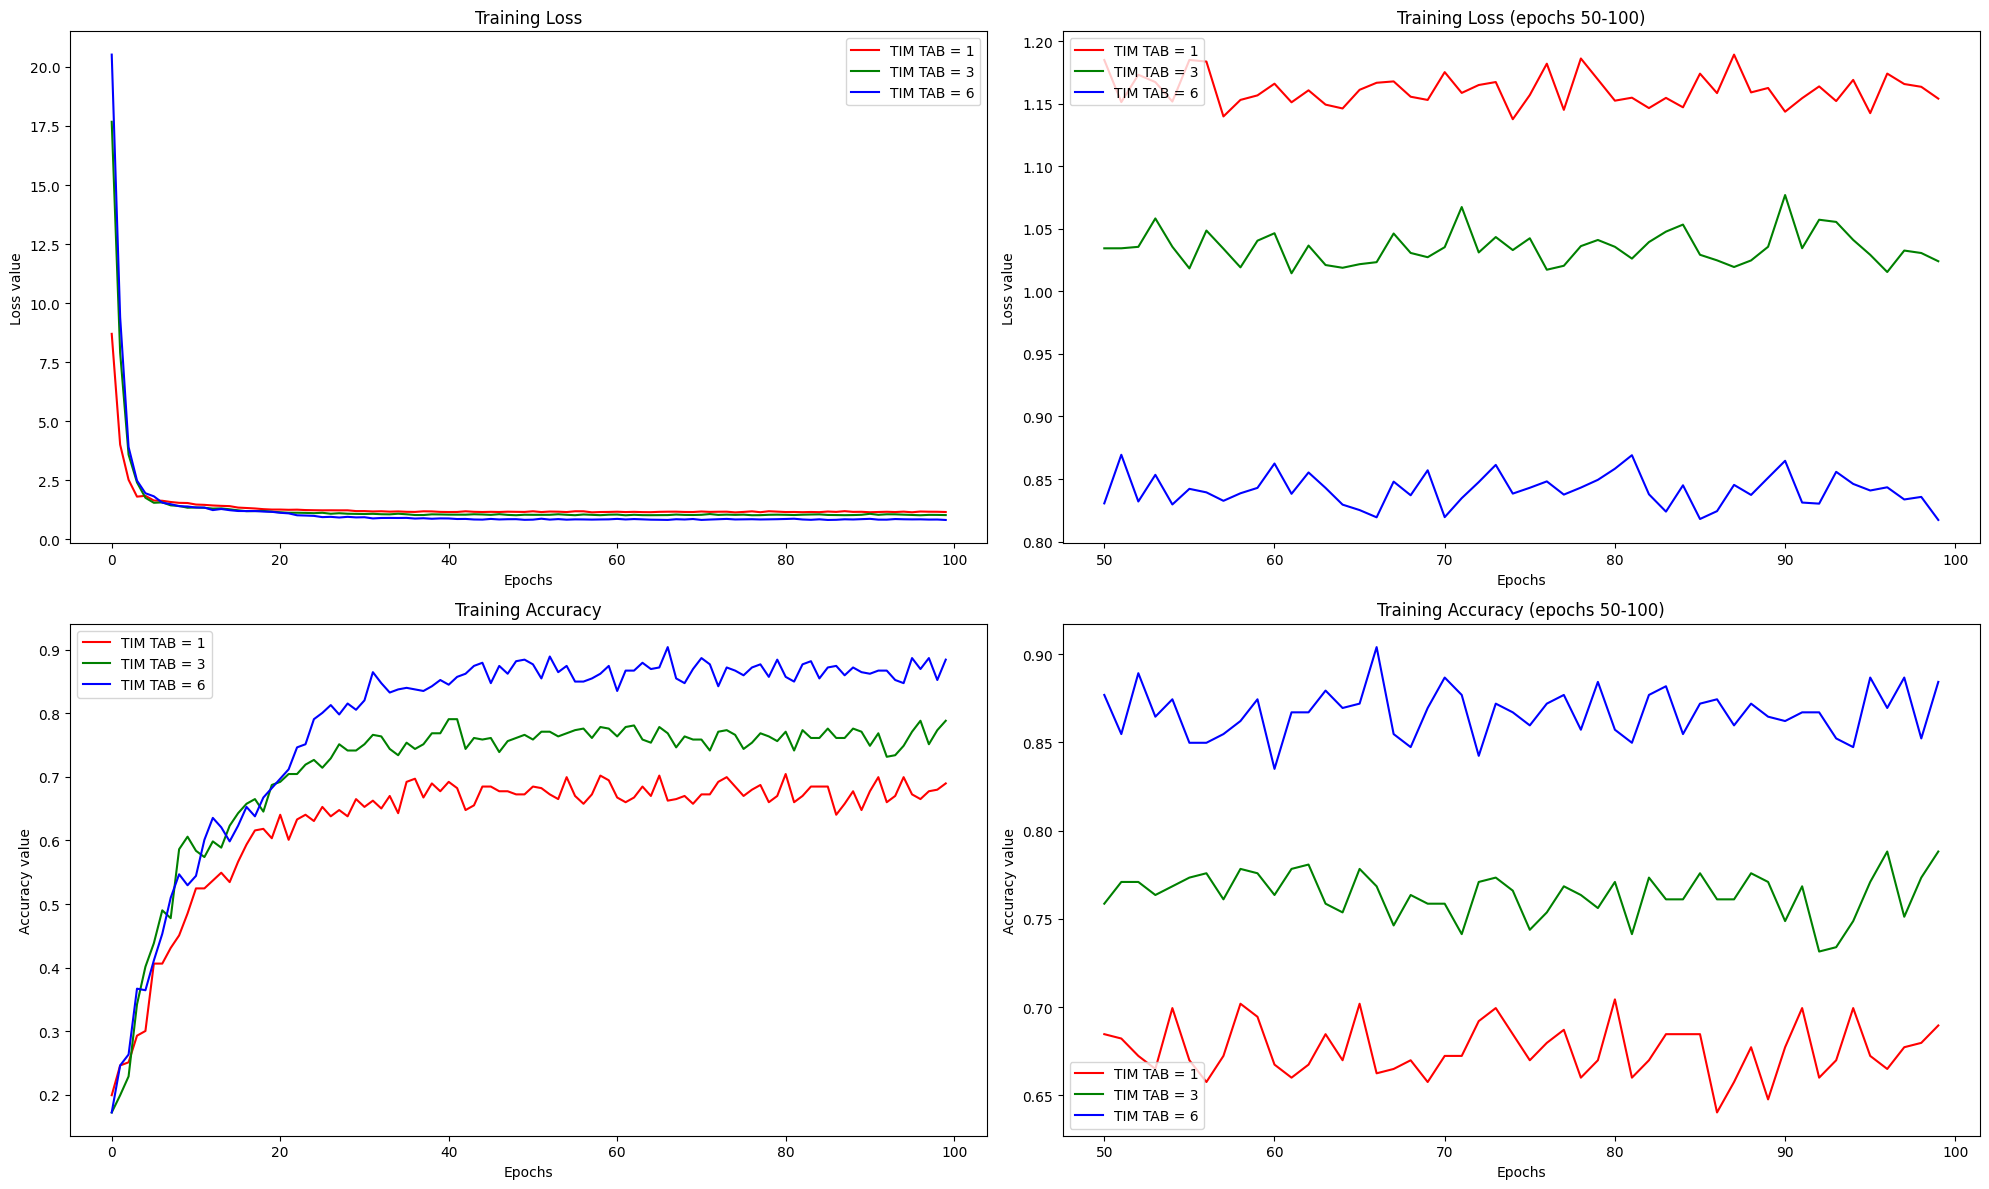

In [6]:
fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(20,12))

# Set the functions, title, x_label, y_label and legend for the loss 
ax[0,0].plot(epochs, training_loss_tim_tab1, label='TIM TAB = 1', color='r')
ax[0,0].plot(epochs, training_loss_tim_tab3, label='TIM TAB = 3', color='g')
ax[0,0].plot(epochs, training_loss_tim_tab6, label='TIM TAB = 6', color='b')
ax[0,0].set_title('Training Loss')
ax[0,0].set_xlabel('Epochs')
ax[0,0].set_ylabel('Loss value')
ax[0,0].legend(loc='upper left')

# Set the functions, title, x_label, y_label and legend for the loss 
ax[0,1].plot(epochs[50:], training_loss_tim_tab1[50:], label='TIM TAB = 1', color='r')
ax[0,1].plot(epochs[50:], training_loss_tim_tab3[50:], label='TIM TAB = 3', color='g')
ax[0,1].plot(epochs[50:], training_loss_tim_tab6[50:], label='TIM TAB = 6', color='b')
ax[0,1].set_title('Training Loss (epochs 50-100)')
ax[0,1].set_xlabel('Epochs')
ax[0,1].set_ylabel('Loss value')
ax[0,1].legend(loc='upper left')

# Set the functions, title, x_label, y_label and legend for the loss 
ax[1,0].plot(epochs, training_acc_tim_tab1, label='TIM TAB = 1', color='r')
ax[1,0].plot(epochs, training_acc_tim_tab3, label='TIM TAB = 3', color='g')
ax[1,0].plot(epochs, training_acc_tim_tab6, label='TIM TAB = 6', color='b')
ax[1,0].set_title('Training Accuracy')
ax[1,0].set_xlabel('Epochs')
ax[1,0].set_ylabel('Accuracy value')
ax[1,0].legend(loc='upper left')

# Set the functions, title, x_label, y_label and legend for the loss 
ax[1,1].plot(epochs[50:], training_acc_tim_tab1[50:], label='TIM TAB = 1', color='r')
ax[1,1].plot(epochs[50:], training_acc_tim_tab3[50:], label='TIM TAB = 3', color='g')
ax[1,1].plot(epochs[50:], training_acc_tim_tab6[50:], label='TIM TAB = 6', color='b')
ax[1,1].set_title('Training Accuracy (epochs 50-100)')
ax[1,1].set_xlabel('Epochs')
ax[1,1].set_ylabel('Accuracy value')
ax[1,1].legend(loc='upper left')

# Display the plot
plt.tight_layout()  # This helps to prevent overlapping of subplots
plt.show()

<font size='6'>Loss/Accuracy CkTIM and TIM comparison</font>

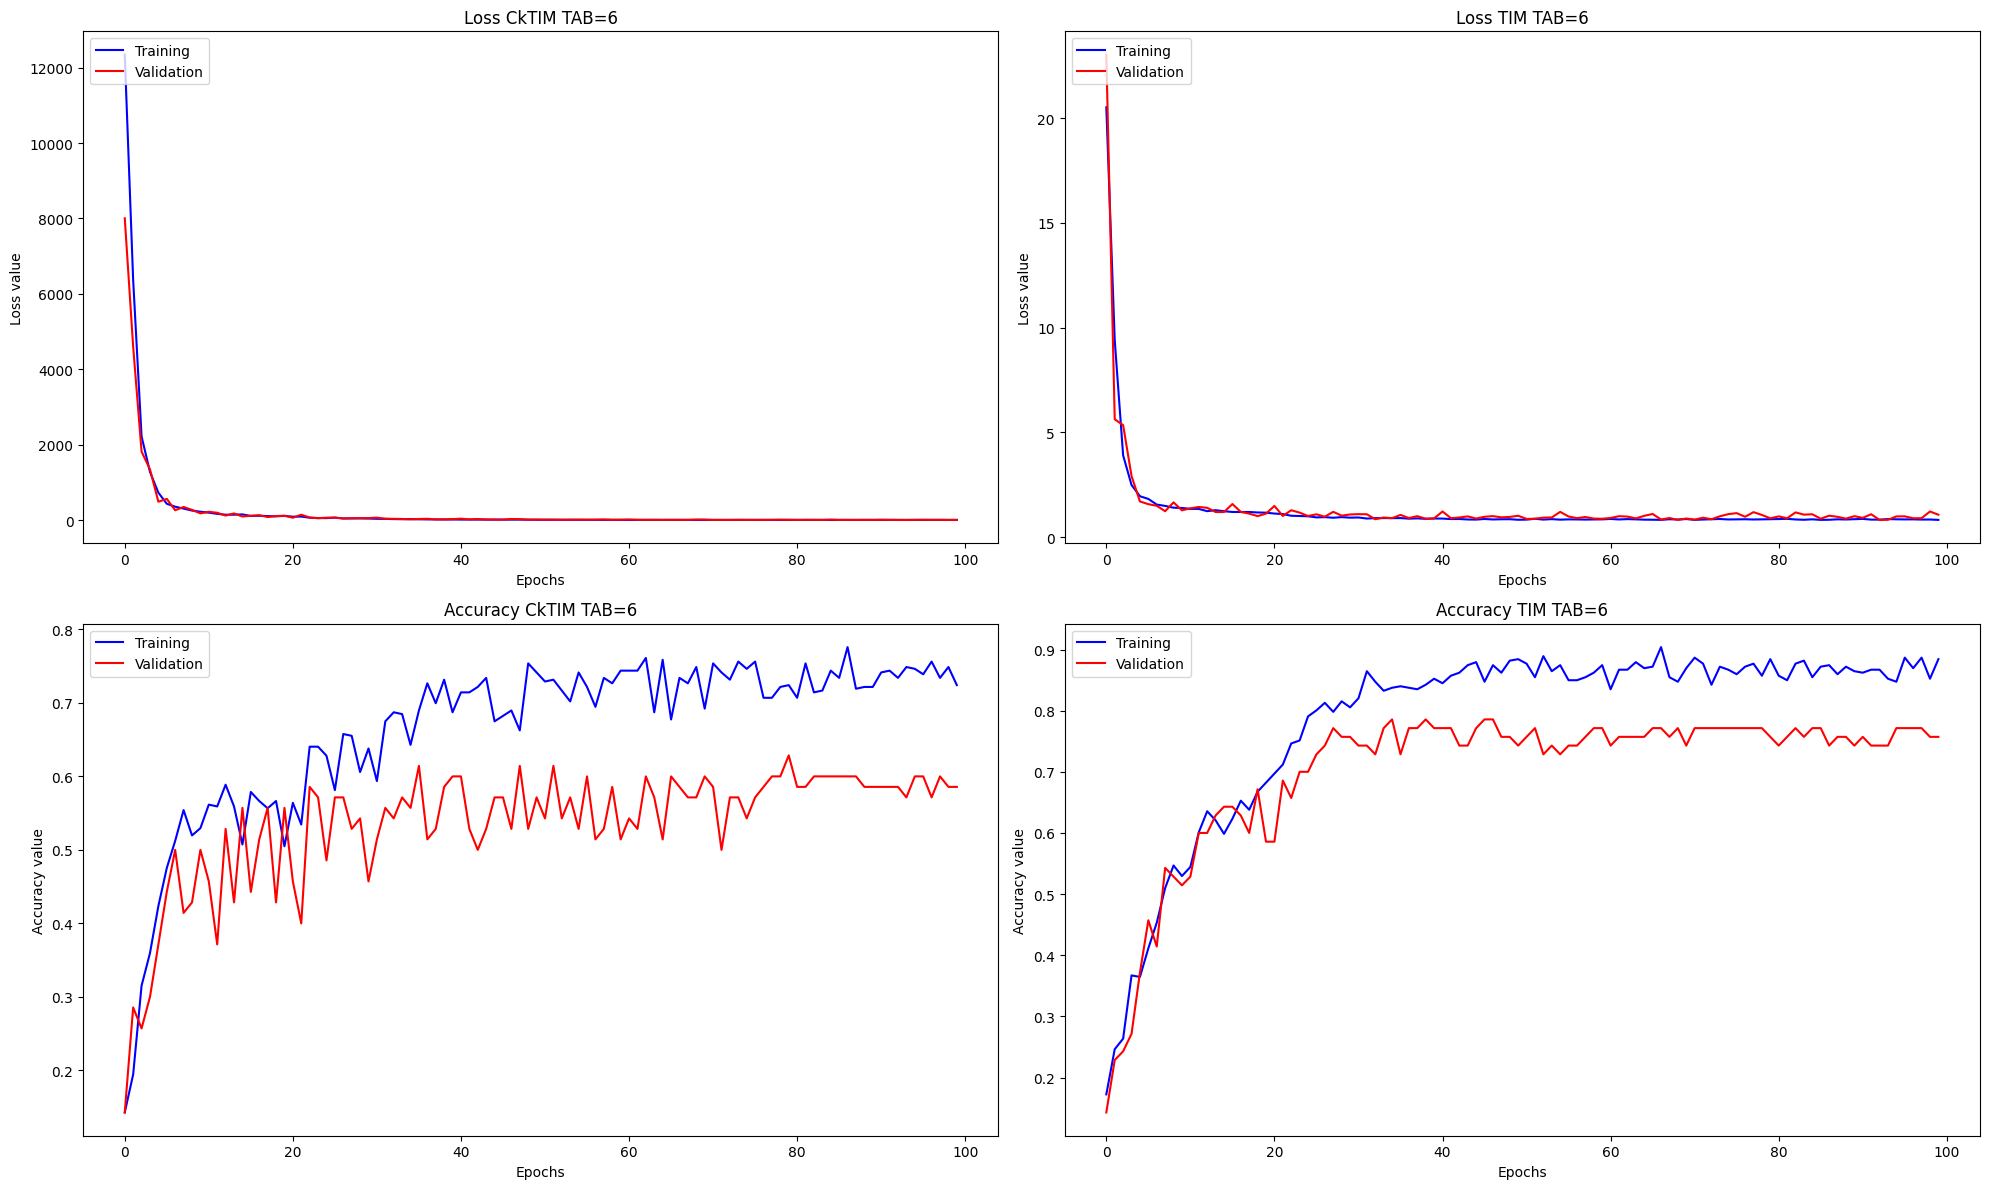

In [10]:
fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(20,12))

# Set the functions, title, x_label, y_label and legend for the loss 
ax[0,0].plot(epochs, training_loss_cktim_tab6, label='Training', color='b')
ax[0,0].plot(epochs, validation_loss_cktim_tab6, label='Validation', color='r')
ax[0,0].set_title('Loss CkTIM TAB=6')
ax[0,0].set_xlabel('Epochs')
ax[0,0].set_ylabel('Loss value')
ax[0,0].legend(loc='upper left')

# Set the functions, title, x_label, y_label and legend for the loss 
ax[0,1].plot(epochs, training_loss_tim_tab6, label='Training', color='b')
ax[0,1].plot(epochs, validation_loss_tim_tab6, label='Validation', color='r')
ax[0,1].set_title('Loss TIM TAB=6')
ax[0,1].set_xlabel('Epochs')
ax[0,1].set_ylabel('Loss value')
ax[0,1].legend(loc='upper left')

# Set the functions, title, x_label, y_label and legend for the loss 
ax[1,0].plot(epochs, training_acc_cktim_tab6, label='Training', color='b')
ax[1,0].plot(epochs, validation_acc_cktim_tab6, label='Validation', color='r')
ax[1,0].set_title('Accuracy CkTIM TAB=6')
ax[1,0].set_xlabel('Epochs')
ax[1,0].set_ylabel('Accuracy value')
ax[1,0].legend(loc='upper left')

# Set the functions, title, x_label, y_label and legend for the loss 
ax[1,1].plot(epochs, training_acc_tim_tab6, label='Training', color='b')
ax[1,1].plot(epochs, validation_acc_tim_tab6, label='Validation', color='r')
ax[1,1].set_title('Accuracy TIM TAB=6')
ax[1,1].set_xlabel('Epochs')
ax[1,1].set_ylabel('Accuracy value')
ax[1,1].legend(loc='upper left')

# Display the plot
plt.tight_layout()  # This helps to prevent overlapping of subplots
plt.show()

<font size='6'>Augmentation effect</font>

In this plots it's possible to see how augmentation increase performances. 

In particular we have trained CkTIM with TAB=6 with the augmented dataset, to compare with CkTIM (TAB=6) trained with the original dataset. 

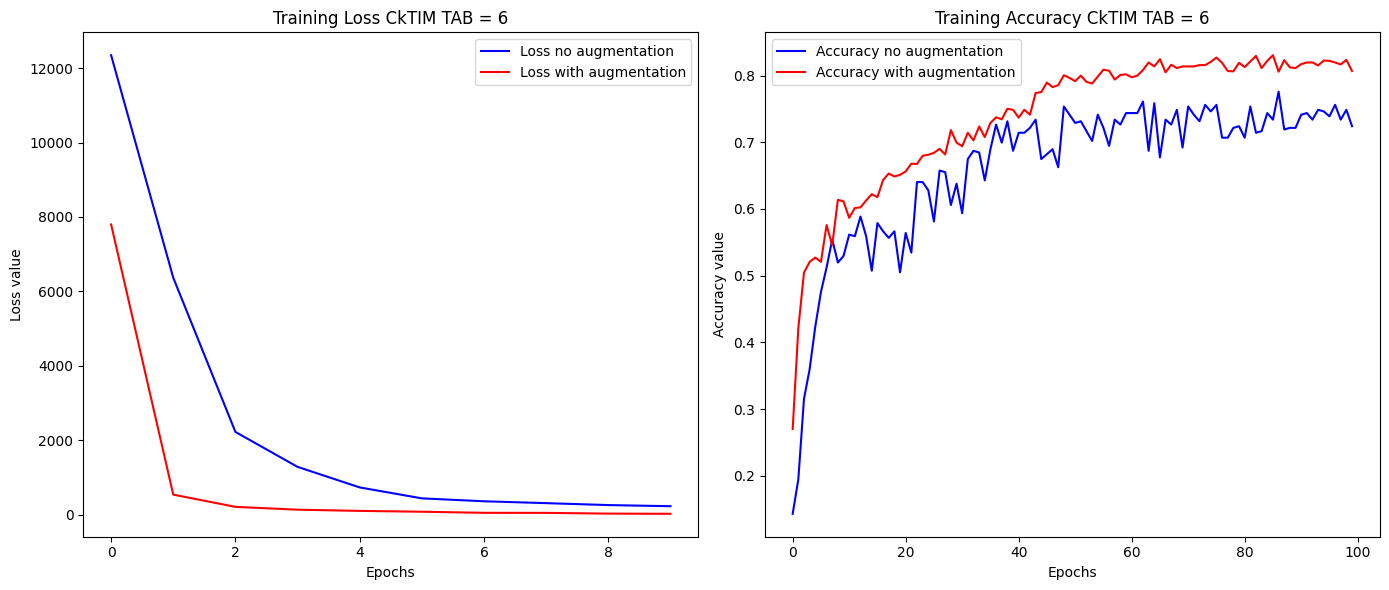

In [9]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(14,6))

# Set the functions, title, x_label, y_label and legend for the loss 
ax[0].plot(epochs[:10], training_loss_cktim_tab6[:10], label='Loss no augmentation', color='b')
ax[0].plot(epochs[:10], training_loss_aug_cktim_tab6[:10], label='Loss with augmentation', color='r')
ax[0].set_title('Training Loss CkTIM TAB = 6')
ax[0].set_xlabel('Epochs')
ax[0].set_ylabel('Loss value')
ax[0].legend()

# Set the functions, title, x_label, y_label and legend for the loss 
ax[1].plot(epochs, training_acc_cktim_tab6, label='Accuracy no augmentation', color='b')
ax[1].plot(epochs, training_acc_aug_cktim_tab6, label='Accuracy with augmentation', color='r')
ax[1].set_title('Training Accuracy CkTIM TAB = 6')
ax[1].set_xlabel('Epochs')
ax[1].set_ylabel('Accuracy value')
ax[1].legend()

# Display the plot
plt.tight_layout()  # This helps to prevent overlapping of subplots
plt.show()

- **Left plot**: it's possible to see how augmentation permits the loss to converge in less epochs to the minimum value. 

- **Right plot**: it's possible to see that augmentation increse the accuracy of the model, permits a better generalization